In [1]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/ICN2/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

from joblib import dump, load
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sisl

/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indic

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [28]:
model_dir = Path("results/h_noc_2")
directory = Path("results_dos/h_noc_2_train")
filename = "train_best_model.tar"

n_atoms = 64
n_orbs_per_atom = 13

In [3]:
config = load_config(model_dir / "config.yaml")

# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)
paths = train_paths + val_paths
basis = get_basis_from_structures_paths(paths, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
model, optimizer, lr_scheduler, loss_fn = init_mace_g2m_model(config, table)

# Load the model
model_path = model_dir / filename
model, checkpoint, optimizer, lr_scheduler = load_model(model, optimizer, model_path, lr_scheduler=None, initial_lr=None, device='cpu')
history = checkpoint["history"]
print(f"Loaded model in epoch {checkpoint["epoch"]} with training loss {checkpoint["train_loss"]} and validation loss {checkpoint["val_loss"]}.")

Basis computation.
Number of structures to look on: 629
Looking for unique atoms in each structure...


1it [00:00, 50.87it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [7, 5]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(atomic_energies, dtype=torch.get_default_dtype()),


Using Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
LR Scheduler:  ReduceLROnPlateau
Arguments:  None
Keyword arguments:  {'cooldown': 0, 'eps': 0.0, 'factor': 0.1, 'min_lr': 0.0, 'mode': 'min', 'patience': 20}
Using Loss function <class 'graph2mat.core.data.metrics.block_type_mse'>
Loaded model in epoch 24782 with training loss 11333.201171875 and validation loss 35070.49609375.


In [16]:
def plot_dos_matplotlib(
    energy, dos,
    predicted_energies=None, predicted_dos=None, filepath=None,
    ylim=None, fermi_lvl=None, legend_loc=None
):
    energy = np.asarray(energy)
    dos = np.asarray(dos)

    fig, ax = plt.subplots(figsize=(3, 5), facecolor="white")
    ax.set_facecolor("white")

    # True dos: label only on the first column
    ax.plot(dos, energy, color="red", lw=2, label="True DOS")

    # Predicted dos
    if predicted_dos is not None:
        predicted_dos = np.asarray(predicted_dos)
        ax.plot(predicted_dos, predicted_energies, color="black", lw=1, ls="--", label="Predicted DOS")

    # Optional Fermi energy
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="blue", ls="--", lw=2, label="Fermi energy")

    # Axes & ticks
    ax.set_xlabel(r"DOS")
    ax.set_ylabel("Energy (eV)")
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

    return fig, ax


# Fermi from Thomas:

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi energy

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi
    

import re
import sys

def read_orbital_count(path="aiida.ORB_INDX") -> int:
    # Look for the pattern "<number> = orbitals" anywhere in the first few lines
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in range(5):  # it's on the first line, but scan a few just in case
            line = f.readline()
            if not line:
                break
            m = re.search(r"\b(\d+)\s*=\s*orbitals\b", line, flags=re.IGNORECASE)
            if m:
                return int(m.group(1))
    raise ValueError("Couldn't find '<number> = orbitals' in the header.")

import numpy as np
import matplotlib.pyplot as plt
import re

def read_fermi_energy(path: str) -> float:
    """
    Return the last reported Fermi energy (in eV) from a SIESTA aiida.out file.
    """
    pat = re.compile(r'Fermi\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    fermi = None
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = pat.search(line)
            if m:
                fermi = float(m.group(1))
    if fermi is None:
        raise ValueError("Fermi energy not found in file.")
    return fermi


Structure  dataset/SHARE_OUTPUTS_64_ATOMS/a8bf-8aa3-4864-8a1c-edfb0bf48c2d
n_B=32, n_N=32
N_orbitals: 104000
n_cells=125
Fermi energy Thomas: 0.0021097703006929883
Fermi energy SIESTA: -5.846653

Structure  dataset/SHARE_OUTPUTS_64_ATOMS/360d-4d90-478a-9b3f-7abad2fd2238
n_B=32, n_N=32
N_orbitals: 22464
n_cells=27
Fermi energy Thomas: 0.002257407509310529
Fermi energy SIESTA: -5.324631

Structure  dataset/SHARE_OUTPUTS_64_ATOMS/e46e-c792-412c-99ac-9e20794f7aad
n_B=32, n_N=32
N_orbitals: 22464
n_cells=27
Fermi energy Thomas: -0.0010426799140013446
Fermi energy SIESTA: -5.70012

Structure  dataset/SHARE_OUTPUTS_64_ATOMS/ae42-0c23-43df-adb6-5f127162d168
n_B=32, n_N=32
N_orbitals: 22464
n_cells=27
Fermi energy Thomas: 0.006337732424774849
Fermi energy SIESTA: -5.636083


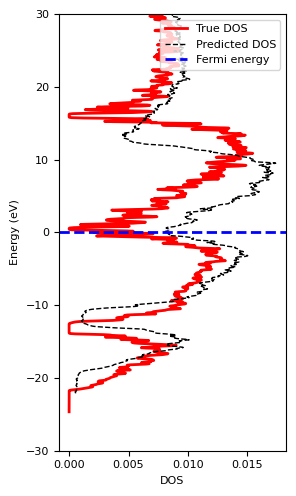

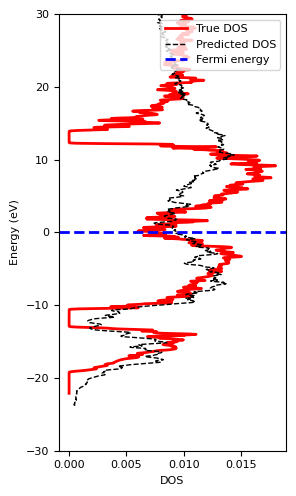

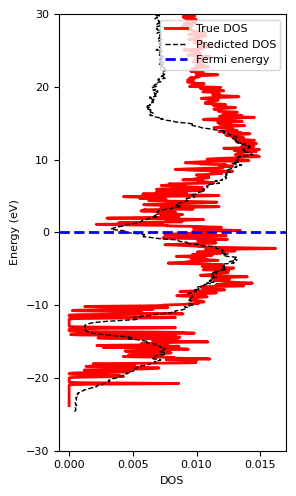

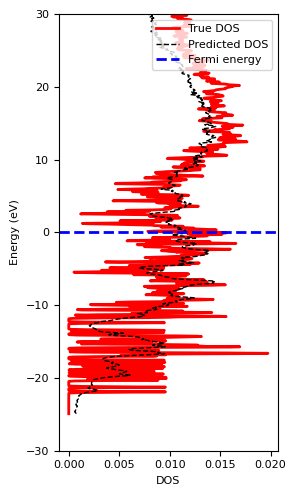

In [57]:
directory_train = Path("results_dos/h_noc_2_train")

dos_true_paths = list(directory_train.glob('train_64*dos*true*'))
dos_pred_paths = list(directory_train.glob('train_64*dos*pred*'))

bands_true_paths = [next((directory_train/"bands").glob(f"*{dos.parts[-1].split("_")[2]}*true.npz")) for dos in dos_true_paths]
bands_pred_paths = [next((directory_train/"bands").glob(f"*{dos.parts[-1].split("_")[2]}*pred.npz")) for dos in dos_true_paths]

for i in range(len(dos_true_paths)):
    path = dos_true_paths[i]
    loaded_file = np.load(path)
    energies_true = loaded_file["energies"]
    dos_true = loaded_file["dos"]

    path = dos_pred_paths[i]
    loaded_file = np.load(path)
    energies_pred = loaded_file["energies"]
    dos_pred = loaded_file["dos"]

    path = Path(f"dataset/SHARE_OUTPUTS_{n_atoms}_ATOMS/{dos_true_paths[i].parts[-1].split("_")[2]}")
    filepath = path / "aiida.ORB_INDX"
    n_orbs_supercell = read_orbital_count(filepath) 
    n_cells = n_orbs_supercell//n_orbs_per_atom//n_atoms
    n_B = np.sum(sisl.get_sile(path / "aiida.fdf").read_geometry().atoms.Z == 5)
    n_N = np.sum(sisl.get_sile(path / "aiida.fdf").read_geometry().atoms.Z == 7)
    fermi_thomas = FindFermi2(energies_true, dos_true, n_orbs_per_atom*n_atoms*n_cells, (3*n_B + 5*n_N)*n_cells, ShowPlot=False)
    fermi_siesta = read_fermi_energy(path / "aiida.out")
    print("\nStructure ", path)
    print(f"n_B={n_B}, n_N={n_N}")
    print("N_orbitals:", n_orbs_supercell)
    print(f"n_cells={n_cells}")
    print("Fermi energy Thomas:", fermi_thomas)
    print("Fermi energy SIESTA:", fermi_siesta)

    ylim = [-30, +30]

    fig_dos, ax = plot_dos_matplotlib(energies_true, dos_true, predicted_energies=energies_pred, predicted_dos=dos_pred, filepath=None, ylim=ylim, fermi_lvl=fermi_thomas, legend_loc="upper right")


Structure  dataset/SHARE_OUTPUTS_64_ATOMS/16eb-54f8-42cb-bdb1-7b16f24a650c
n_B=32, n_N=32
N_orbitals: 22464
n_cells=27
Fermi energy Thomas: 0.0028301346410057465
Fermi energy SIESTA: -5.606397


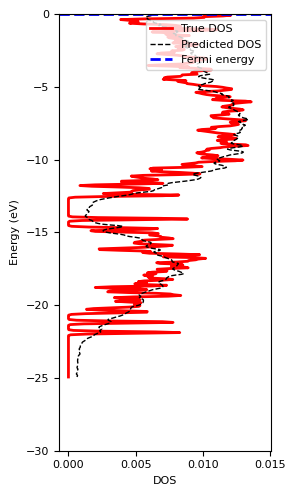

In [56]:
directory_train = Path("results_dos/h_noc_2_val")

dos_true_paths = list(directory_train.glob('val_64*dos*true*'))
dos_pred_paths = list(directory_train.glob('val_64*dos*pred*'))

bands_true_paths = [next((directory_train/"bands").glob(f"*{dos.parts[-1].split("_")[2]}*true.npz")) for dos in dos_true_paths]
bands_pred_paths = [next((directory_train/"bands").glob(f"*{dos.parts[-1].split("_")[2]}*pred.npz")) for dos in dos_true_paths]

for i in range(len(dos_true_paths)):
    path = dos_true_paths[i]
    loaded_file = np.load(path)
    energies_true = loaded_file["energies"]
    dos_true = loaded_file["dos"]

    path = dos_pred_paths[i]
    loaded_file = np.load(path)
    energies_pred = loaded_file["energies"]
    dos_pred = loaded_file["dos"]

    path = Path(f"dataset/SHARE_OUTPUTS_{n_atoms}_ATOMS/{dos_true_paths[i].parts[-1].split("_")[2]}")
    filepath = path / "aiida.ORB_INDX"
    n_orbs_supercell = read_orbital_count(filepath) 
    n_cells = n_orbs_supercell//n_orbs_per_atom//n_atoms
    n_B = np.sum(sisl.get_sile(path / "aiida.fdf").read_geometry().atoms.Z == 5)
    n_N = np.sum(sisl.get_sile(path / "aiida.fdf").read_geometry().atoms.Z == 7)
    fermi_thomas = FindFermi2(energies_true, dos_true, n_orbs_per_atom*n_atoms*n_cells, (3*n_B + 5*n_N)*n_cells, ShowPlot=False)
    fermi_siesta = read_fermi_energy(path / "aiida.out")
    print("\nStructure ", path)
    print(f"n_B={n_B}, n_N={n_N}")
    print("N_orbitals:", n_orbs_supercell)
    print(f"n_cells={n_cells}")
    print("Fermi energy Thomas:", fermi_thomas)
    print("Fermi energy SIESTA:", fermi_siesta)

    ylim = [-30, +0]

    fig_dos, ax = plot_dos_matplotlib(energies_true, dos_true, predicted_energies=energies_pred, predicted_dos=dos_pred, filepath=None, ylim=ylim, fermi_lvl=fermi_thomas, legend_loc="upper right")

In [46]:
#sanity check

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear',
               ShowPlot=False, return_debug=False):
    """
    Estimates E_Fermi from a (spinless or spin-summed) DOS by counting states.

    NEW: If return_debug=True, also returns a dict with:
      - total_raw_integral: ∫ DOS(E) dE over your full window (spinless states)
      - scale_to_N_orbitals: factor used to rescale cum. integral to N_orbitals
      - cum_states_top_scaled: cumulative states at top of window after scaling
      - target_filled_states: N_electrons/2
      - filling_fraction: (N_electrons/2)/N_orbitals
      - ind_fermi: index just above the Fermi crossing
    """

    energies = np.asarray(energies, dtype=float)
    dos = np.asarray(dos, dtype=float)
    if energies.shape != dos.shape:
        raise ValueError("energies and dos must have the same shape.")

    # Ensure strictly increasing energies (sort if needed)
    if np.any(np.diff(energies) <= 0):
        idx = np.argsort(energies)
        energies = energies[idx]
        dos = dos[idx]

    # --- Sanity check integral over the WHOLE window (raw, unnormalized)
    cum_int_raw = integrate.cumulative_trapezoid(dos, energies, initial=0.0)
    total_raw_integral = cum_int_raw[-1]  # "number of spinless states" per how the DOS is normalized

    # Rescale cumulative integral so that the top equals N_orbitals (like before)
    if total_raw_integral == 0:
        raise ValueError("Total integral of DOS over the provided energy window is zero.")
    scale = N_orbitals / total_raw_integral
    cum_int = cum_int_raw * scale

    cross_val = N_electrons / 2.0  # number of filled spinless states

    # Guard: do we actually reach the needed number of filled states within the window?
    if cum_int[-1] < cross_val:
        msg = (f"Energy window too small or mismatched normalization: "
               f"cum_states(top)={cum_int[-1]:.6g} < target_filled_states={cross_val:.6g}. "
               "Expand the energy range and/or check N_orbitals vs DOS normalization.")
        raise ValueError(msg)

    # First index that crosses the target
    ind_Fermi = int(np.searchsorted(cum_int, cross_val))

    # Estimate E_Fermi
    if mode == 'discrete' or ind_Fermi == 0 or cum_int[ind_Fermi] == cum_int[ind_Fermi-1]:
        E_Fermi = energies[ind_Fermi]
    else:
        x1, y1 = energies[ind_Fermi-1], cum_int[ind_Fermi-1]
        x2, y2 = energies[ind_Fermi],   cum_int[ind_Fermi]
        E_Fermi = (cross_val - y1) * (x2 - x1) / (y2 - y1) + x1

    if ShowPlot:
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS\, dE$ (scaled)')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{e^-}/2$')
        plt.axvline(E_Fermi, color='black', ls='--', label=rf'$E_F\approx{E_Fermi:.3f}$')
        plt.xlabel(r'Energy $E$')
        plt.ylabel('Cumulative spinless states')
        plt.legend()
        plt.show()

    if return_debug:
        debug = {
            "total_raw_integral": float(total_raw_integral),
            "scale_to_N_orbitals": float(scale),
            "cum_states_top_scaled": float(cum_int[-1]),
            "target_filled_states": float(cross_val),
            "filling_fraction": float(cross_val / N_orbitals),
            "ind_fermi": int(ind_Fermi),
        }
        return E_Fermi, debug

    return E_Fermi


fermi_thomas, dbg = FindFermi2(
    energies_true,
    dos_true,
    n_orbs_per_atom * n_atoms * n_cells,
    (3*n_B + 5*n_N) * n_cells,
    ShowPlot=False,
    return_debug=True
)

print(f"∫ DOS dE over window (raw) = {dbg['total_raw_integral']:.6g} states (spinless)")
print(f"Rescale factor to N_orbitals = {dbg['scale_to_N_orbitals']:.6g}")
print(f"Cumulative states at top (scaled) = {dbg['cum_states_top_scaled']:.6g} "
      f"(should be ≈ N_orbitals={n_orbs_per_atom * n_atoms * n_cells})")
print(f"Target filled states (N_e/2) = {dbg['target_filled_states']:.6g}")
print(f"Filling fraction = {dbg['filling_fraction']:.6g}")
print(f"E_F (eV) = {fermi_thomas:.6f}")


∫ DOS dE over window (raw) = 1 states (spinless)
Rescale factor to N_orbitals = 22464
Cumulative states at top (scaled) = 22464 (should be ≈ N_orbitals=22464)
Target filled states (N_e/2) = 3456
Filling fraction = 0.153846
E_F (eV) = 0.006338


In [ ]:
# Plot all training 64 structures of the model hnoc2.
directory_train = Path("results_dos/h_noc_2_train")


file = sisl.get_sile(path / "aiida.fdf")
fig = file.plot.geometry(axes="xyz")
# filepath = savedir_struct / f"{n_atoms}atm_{structure}.png"
# fig.write_image(str(filepath))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    showlegend=False,
)
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_structure.png"
dir = Path("exports") / model_dir.parts[-1] 
filepath = dir/ filename
dir.mkdir(exist_ok=True, parents=True)
fig.write_image(filepath)

/tmp/ipykernel_1439412/2828579389.py:18: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1439412/2828579389.py:18: RuntimeWarning:

invalid value encountered in divide



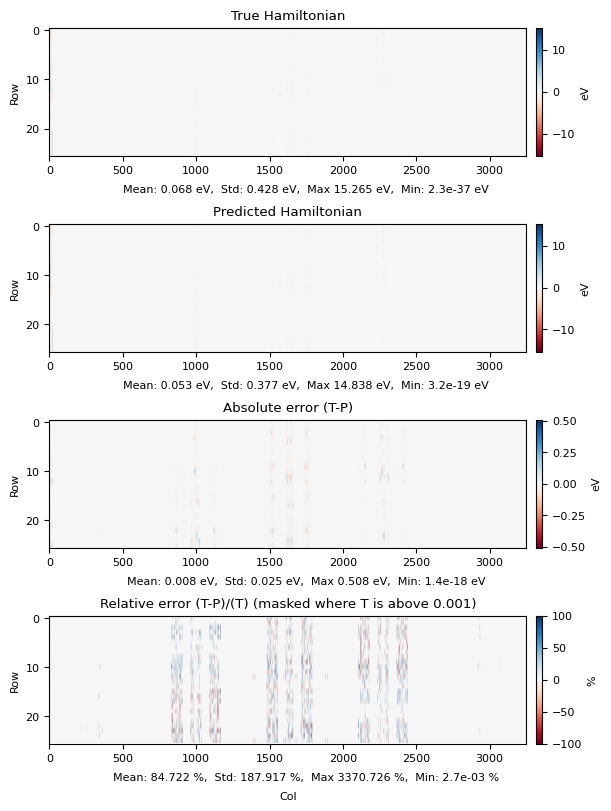

In [33]:
# Plot hamiltonian

def plot_hamiltonian_matplotlib(true_matrix, predicted_matrix, matrix_label=None, figure_title=None, predicted_matrix_text=None, filepath=None, force_max_colorbar_abs_error=None, only_first_uc=False):
    """Matplotlib visualization of error matrices."""

    if only_first_uc:
        n_orbs = true_matrix.shape[0]
        true_matrix = true_matrix[:, :n_orbs]
        predicted_matrix = predicted_matrix[:, :n_orbs]
        figsize=(4, 8)
    else:
        figsize=(6, 8)

    # Error matrices
    absolute_error_matrix = true_matrix - predicted_matrix
    threshold = 0.001
    mask = true_matrix >= threshold
    relative_error_matrix = np.where(mask, absolute_error_matrix / (true_matrix) * 100, 0)

    # Colorbar limits
    vmin = np.min([np.min(true_matrix), np.min(predicted_matrix)])
    vmax = np.max([np.max(true_matrix), np.max(predicted_matrix)])
    lim_data = max(np.abs(vmin), np.abs(vmax))

    if force_max_colorbar_abs_error is None:
        lim_abs = np.max(np.abs(absolute_error_matrix))
    else:
        lim_abs = force_max_colorbar_abs_error

    lim_rel = 100.0  # %

    cbar_limits = [lim_data, lim_data, lim_abs, lim_rel]

    # Titles
    if matrix_label is None:
        matrix_label = ''
    titles = [
        "True " + matrix_label,
        "Predicted " + matrix_label,
        "Absolute error (T-P)",
        f"Relative error (T-P)/(T) (masked where T is above {threshold})"
    ]
    cbar_titles = ["eV", "eV", "eV", "%"]

    # Matrices to plot
    matrices = [true_matrix, predicted_matrix, absolute_error_matrix, relative_error_matrix]

    fig, axes = plt.subplots(4, 1, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.15})
    # fig.suptitle(figure_title if figure_title else "Matrix Comparison and Errors", fontsize=16)

    for i, (matrix, ax) in enumerate(zip(matrices, axes)):
        im = ax.imshow(matrix, cmap='RdBu', vmin=-cbar_limits[i], vmax=cbar_limits[i])
        ax.set_title(titles[i])
        ax.set_ylabel("Row")
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)
        cbar.set_label(cbar_titles[i])
        if i==3:
            ax.set_xlabel("Col", labelpad=20)
        ax.set_aspect('auto')
        

    y_offset = 0.035
    addition = 0.245
    # True matrix stats (exclude zeros for stats)
    matrix_nnz = np.abs(true_matrix)[true_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 3*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Predicted stats
    matrix_nnz = np.abs(predicted_matrix)[predicted_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 2*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Absolute error stats (exclude zeros for stats)
    matrix_nnz = np.abs(absolute_error_matrix)[absolute_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 1*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Relative error stats (exclude zeros for stats)
    matrix_nnz = np.abs(relative_error_matrix)[relative_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 0*addition,
        fr"Mean: {mean:.3f} %,  Std: {std:.3f} %,  Max {vmax:.3f} %,  Min: {vmin:.1e} %",
        ha='center', va='center', fontsize=8,
    )

    # axes[-1].set_xlabel(" ")

    # Output
    if filepath:
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close(fig)
    return fig

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian")
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_ham.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

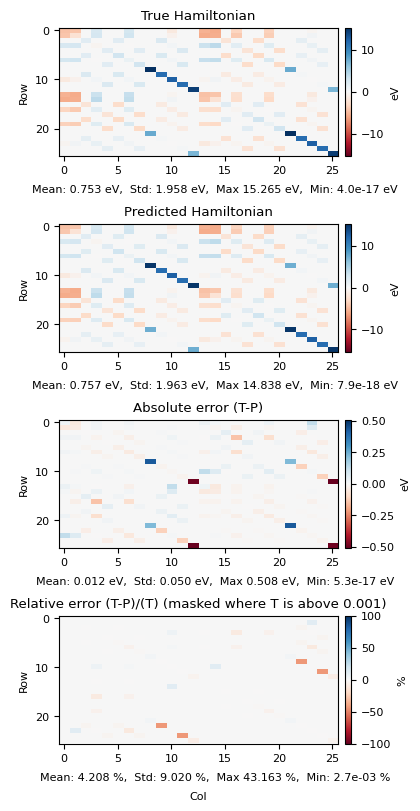

In [34]:
# Plot only the zero shift

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian", only_first_uc=True)
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_ham_little.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

# Bands, Fermi Energy, DOS

In [ ]:
# Fermi from Thomas:

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi energy

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi
    

import re
import sys

def read_orbital_count(path="aiida.ORB_INDX") -> int:
    # Look for the pattern "<number> = orbitals" anywhere in the first few lines
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in range(5):  # it's on the first line, but scan a few just in case
            line = f.readline()
            if not line:
                break
            m = re.search(r"\b(\d+)\s*=\s*orbitals\b", line, flags=re.IGNORECASE)
            if m:
                return int(m.group(1))
    raise ValueError("Couldn't find '<number> = orbitals' in the header.")

filepath = path / "aiida.ORB_INDX"
print(read_orbital_count(filepath))

3250


Data extracted from results_dos/h_noc_2_train/2atm_18a7-265b-4fbf-aae4-52fb83b4760f_dos_mesh30_true.npz
Fermi_thomas: -7.485805418016586
Fermi_siesta: -7.58465


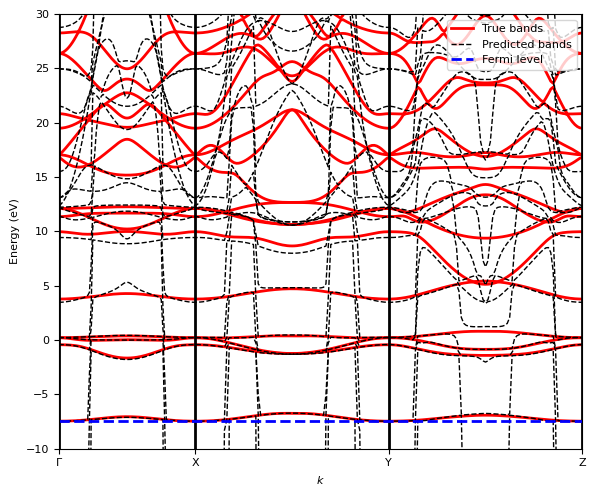

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

def read_fermi_energy(path: str) -> float:
    """
    Return the last reported Fermi energy (in eV) from a SIESTA aiida.out file.
    """
    pat = re.compile(r'Fermi\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    fermi = None
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = pat.search(line)
            if m:
                fermi = float(m.group(1))
    if fermi is None:
        raise ValueError("Fermi energy not found in file.")
    return fermi

def plot_bands_matplotlib(k_len, bands, k_idx, k_label,
                          predicted_bands=None, filepath=None,
                          ylim=None, fermi_lvl=None, legend_loc=None):
    k_len = np.asarray(k_len)
    bands = np.asarray(bands)
    assert bands.ndim == 2, "bands must be (n_kpoints, n_bands)"

    fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
    ax.set_facecolor("white")

    # True bands: label only on the first column
    ax.plot(k_len, bands[:, 0], color="red", lw=2, label="True bands")
    ax.plot(k_len, bands[:, 1:], color="red", lw=2)  # no label

    # Predicted bands
    if predicted_bands is not None:
        predicted_bands = np.asarray(predicted_bands)
        assert predicted_bands.shape == bands.shape
        ax.plot(k_len, predicted_bands[:, 0], color="black", lw=1, ls="--", label="Predicted bands")
        ax.plot(k_len, predicted_bands[:, 1:], color="black", lw=1, ls="--")  # no label

    # Decide vertical line span
    if ylim is not None:
        vmin, vmax = ylim
    else:
        vmin = np.nanmin(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))
        vmax = np.nanmax(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))

    # Vertical separators
    ax.vlines(k_len[np.asarray(k_idx, int)], vmin, vmax, colors="black", lw=2)

    # Optional Fermi energy
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="blue", ls="--", lw=2, label="Fermi energy")

    # Axes & ticks
    ax.set_xlabel(r"$k$")
    ax.set_ylabel("Energy (eV)")
    ax.set_xlim(k_len.min(), k_len.max())
    ax.set_xticks(k_len[np.asarray(k_idx, int)])
    ax.set_xticklabels(k_label)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")
    for s in ax.spines.values():
        s.set_color("black")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")
    else:
        plt.show()

    return fig, ax

struct = f"{n_atoms}atm_" + structure
directory_bands = directory / "bands"

# Bands

# True
filename = struct + "_bands_true.npz"
filename = directory_bands / filename
loaded_file = np.load(filename)

k_idx = loaded_file["k_idx"]
k_label = loaded_file["k_label"]
energy = loaded_file["k_len"]
bands_true_paths = loaded_file["bands"]

# Pred
filename = struct + "_bands_pred.npz"
filename = directory_bands / filename
loaded_file = np.load(filename)

bands_pred_paths = loaded_file["bands"]

k_len_plot = np.repeat(energy[:,None], bands_true_paths.shape[0], axis=1)
fermi_lvl=read_fermi_energy(path / "aiida.out")


#DOS
# True
filename = struct + "_dos_mesh30_true.npz"
filename = directory / filename
loaded_file = np.load(filename)
print("Data extracted from", filename)

energies = loaded_file["energies"]
dos_true_paths = loaded_file["dos"]

# Pred
# filename = struct + "_dos_mesh30_pred.npz"
# filename = directory / filename
# # loaded_file = np.load(filename)

energies_pred = loaded_file["energies"]
dos_pred_paths = loaded_file["dos"]

#FERMI
filepath = path / "aiida.ORB_INDX"
n_orbs_supercell = read_orbital_count(filepath)
fermi_lvl_thomas = FindFermi2(energies, dos_true_paths, n_orbs_supercell, 8, ShowPlot=False)
print("Fermi_thomas:", fermi_lvl_thomas)
fermi_lvl=read_fermi_energy(path / "aiida.out")
print("Fermi_siesta:", fermi_lvl)



# fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
ylim=[-10, 30]
fig_bands, ax = plot_bands_matplotlib(energy, bands_true_paths, k_idx, k_label, predicted_bands=bands_pred_paths, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl_thomas, legend_loc="upper right")

filename = f"{split}_{n_atoms}atm_{structure}_bands.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
# fig_bands.savefig(str(filepath), dpi=150, bbox_inches="tight")

Fermi_thomas: -7.485805418016586
Fermi level: -7.58465


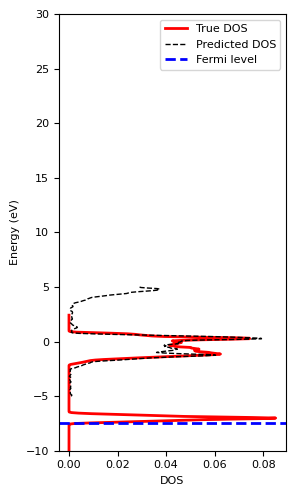

In [ ]:
def plot_dos_matplotlib(
    energy, dos,
    predicted_energies=None, predicted_dos=None, filepath=None,
    ylim=None, fermi_lvl=None, legend_loc=None
):
    energy = np.asarray(energy)
    dos = np.asarray(dos)

    fig, ax = plt.subplots(figsize=(3, 5), facecolor="white")
    ax.set_facecolor("white")

    # True dos: label only on the first column
    ax.plot(dos, energy, color="red", lw=2, label="True DOS")

    # Predicted dos
    if predicted_dos is not None:
        predicted_dos = np.asarray(predicted_dos)
        ax.plot(predicted_dos, predicted_energies, color="black", lw=1, ls="--", label="Predicted DOS")

    # Optional Fermi energy
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="blue", ls="--", lw=2, label="Fermi energy")

    # Axes & ticks
    ax.set_xlabel(r"DOS")
    ax.set_ylabel("Energy (eV)")
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

    return fig, ax

# DOS

# True
filename = struct + "_dos_mesh30_true.npz"
filename = directory / filename
loaded_file = np.load(filename)

energies = loaded_file["energies"]
dos_true_paths = loaded_file["dos"]

filepath = path / "aiida.ORB_INDX"
n_orbs_supercell = read_orbital_count(filepath)
fermi_lvl_thomas = FindFermi2(energies, dos_true_paths, n_orbs_supercell, 8, ShowPlot=False)
print("Fermi_thomas:", fermi_lvl_thomas)

# Pred
filename = struct + "_dos_mesh30_pred.npz"
filename = directory / filename
loaded_file = np.load(filename)

energies_pred = loaded_file["energies"]
dos_pred_paths = loaded_file["dos"]

fermi_lvl=read_fermi_energy(path / "aiida.out")
print("Fermi energy:", fermi_lvl)

# fig_bands = plot_dos_matplotlib(energies, dos_true, predicted_energies=None, predicted_dos=None, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl, legend_loc="upper right")
fig_dos, ax = plot_dos_matplotlib(energies, dos_true_paths, predicted_energies=energies_pred, predicted_dos=dos_pred_paths, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl_thomas, legend_loc="upper right")

filename = f"{split}_{n_atoms}atm_{structure}_dos.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
# fig_dos.savefig(str(filepath), dpi=150, bbox_inches="tight")

# Fermi energy sanity checks

In [41]:
import re
import sys

def read_orbital_count(path="aiida.ORB_INDX") -> int:
    # Look for the pattern "<number> = orbitals" anywhere in the first few lines
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in range(5):  # it's on the first line, but scan a few just in case
            line = f.readline()
            if not line:
                break
            m = re.search(r"\b(\d+)\s*=\s*orbitals\b", line, flags=re.IGNORECASE)
            if m:
                return int(m.group(1))
    raise ValueError("Couldn't find '<number> = orbitals' in the header.")

filepath = path / "aiida.ORB_INDX"
print(read_orbital_count(filepath))

3250


In [ ]:
# For a 2 atm struct:
n_orbs_per_atom = 13
n_atoms_int = int(n_atoms)
filepath = path / "aiida.ORB_INDX"
n_orbs_supercell = read_orbital_count(filepath)
print("SIESTA Fermi energy:", read_fermi_energy(path / "aiida.out"))
print("Thomas Fermi energy with N_orbs=n_orbs_per_atom:", FindFermi2(energies, dos_true_paths, n_orbs_per_atom, 8, ShowPlot=False))
print("Thomas Fermi energy with N_orbs=n_orbs_per_atom*n_atoms_int:", FindFermi2(energies, dos_true_paths, n_orbs_per_atom*n_atoms_int, 8, ShowPlot=False))
print("Thomas Fermi energy with N_orbs=n_orbs_supercell:", FindFermi2(energies, dos_true_paths, n_orbs_supercell, 8, ShowPlot=False))

SIESTA Fermi level: -7.58465
Thomas Fermi level with N_orbs=n_orbs_per_atom: -1.4107706783512128
Thomas Fermi level with N_orbs=n_orbs_per_atom*n_atoms_int: -6.971958822196955
Thomas Fermi level with N_orbs=n_orbs_supercell: -7.485805418016586
